<center>


# ARHITEKTURA NEURONSKIH MREŽA
## 2023./2024.
## Projekt - Analiza hiperparametara
#### Marko Bonovil
#### 3. dio
</center>


#Biblioteke

In [ ]:
import os
import math
import time
import pickle
import numpy as np
import pandas as pd
from math import exp
import seaborn as sns
import tensorflow as tf
from keras import losses
from sklearn import metrics
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras import initializers, optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adagrad, Adam, RMSprop, SGD
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [ ]:
!pip install scikeras
from scikeras.wrappers import KerasClassifier

#Učitavanje skupa podataka

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Arhitekture neuronskih mreža/Projekt

/content/drive/MyDrive/Arhitekture neuronskih mreža/Projekt


In [ ]:
X_train_undersampling=pd.read_csv("X_train_undersampling.csv")
y_train_undersampling=pd.read_csv("y_train_undersampling.csv")
X_val=pd.read_csv("X_val")
y_val=pd.read_csv("y_val")
X_test=pd.read_csv("X_test")
y_test=pd.read_csv("y_test")
tf.random.set_seed(42)

#Odabir hiperparametara za model

##RandomizedSearchCV

**Primjena Random Searh algoritma za odabir kombinacija hiperparametara.**

Random Search CV je tehnika koja istražuje unaprijed definirani prostor pretraživanja hiperparametara nasumičnim odabirom kombinacija za procjenu izvedbe modela. Umjesto da sustavno ispituje sve moguće kombinacije, Random Search CV odabire fiksni broj kombinacija nasumično. Ovaj pristup nudi nekoliko prednosti:
* Nasumično uzorkovanje kombinacija hiperparametara omogućuje da pretraga istraži širok raspon mogućnosti, potencijalno otkrivajući nekonvencionalne konfiguracije koje bi mogle dovesti do poboljšane izvedbe modela.
* manje je računalno intenzivan u usporedbi s iscrpnim tehnikama kao što je Grid Search CV, budući da ne zahtijeva procjenu svake moguće kombinacije. Omogućuje dobru ravnotežu između učinkovitosti pretraživanja i točnosti podešavanja.
* nasumičnim pretraživanjem posebno je koristan kada se radi o velikom broju hiperparametara, budući da iscrpna procjena svih kombinacija može biti nepraktična ili dugotrajna.

Budući da Random Search CV nasumično odabire kombinacije, ne postoji jamstvo pronalaženja apsolutno najboljeg skupa hiperparametara.

In [ ]:
def konstrukcija_modela(sloj_1, sloj_2, sloj_3, akt_funkcija1, akt_funkcija2, optim, learning_rate):

    tf.keras.backend.clear_session()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=float(learning_rate),
        decay_steps=65,
        decay_rate=0.96,
        staircase=False
    )
    optimizer = None
    if optim == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    elif optim == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optim == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
    elif optim == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
    else:
        raise ValueError(f"Unsupported optimizer: {optim}")

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_undersampling.shape[1],)),
        tf.keras.layers.Dense(sloj_1, activation=akt_funkcija1),
        tf.keras.layers.Dense(sloj_2, activation=akt_funkcija1),
        tf.keras.layers.Dense(sloj_3, activation=akt_funkcija1),
        tf.keras.layers.Dense(1, activation=akt_funkcija2)
    ])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Recall'])
    return model

Definiranje početnih kombinacija hiperparametara od kojih počinje analiza

In [ ]:
model = KerasClassifier(
    model=konstrukcija_modela,
    sloj_1=27,
    sloj_2=17,
    sloj_3=7,
    akt_funkcija1='sigmoid',
    akt_funkcija2='sigmoid',
    optim='adam',
    learning_rate=0.01,
    epochs=80,
    batch_size=128,
    verbose=0,
    random_state=42
)

Definiranje skupa vrijednosti svih traženih hiperparametara

In [ ]:
parametri = {
    'sloj_1': [27, 30, 75],
    'sloj_2': [17, 20, 35],
    'sloj_3': [7, 10, 15],
    'akt_funkcija1': ['sigmoid', 'relu', 'tanh'],
    'akt_funkcija2': ['sigmoid'],
    'optim': ['adam', 'sgd', 'rmsprop', 'adagrad'],
    'learning_rate': [0.01, 0.001, 0.1],
    'epochs': [80, 90, 100],
    'batch_size': [128, 256, 1024]
}
scoring = {
    'auc': 'roc_auc',
    'accuracy': 'accuracy',
    'recall': 'recall'
}

 Implementacija stratificirane K-Fold cross-validaciju. Stratificirana cross-validacija osigurava da su proporcije klasa u svakom skupu podataka slične kao i u izvornom skupu podataka.

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

Inicijalizacija Random Search-a sa sljedećim parametrima:
* estimator = model - označava model koji će se koristiti za optimizaciju
* scoring = scoring - označava metrike koje će se mjeriti na modelima tijeko izvršavanje pretrage kombinacija hiperparametara
* refit = 'accuracy' - označava metriku na osnovu koje će se odabirati anjbolja kombinacija
* return_train_score = True - označava da će se rezultati treniranja vratiti
* n_iter = 254 - označava broj iteracija po zadanim hiperparametrima
* cv = stratified_kfold - označava metodu cross-validacije koja će se koristiti za evaluaciju svake kombinacije hiperparametara

In [ ]:
sequentialsearch_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=parametri,
    scoring=scoring,
    verbose=2,
    refit='accuracy',
    return_train_score=True,
    n_iter = 254,
    cv = stratified_kfold
)

Inicijalizirana je pretraga pomoću algoritma Random Search tako da odgovara prvoj pretrazi sa Hyperband algoritmom, po količini iteracija, stoga će Random Search algoritam pronaći 254 kombinacije hiperparametara koje će ispitati u 2 cross-validacije

In [ ]:
pocetno_vrijeme = time.time();
sequentialsearch_cv.fit(
    X_train_undersampling, y_train_undersampling,
    validation_data = (X_val, y_val),
)
krajnje_vrijeme = time.time();

Fitting 2 folds for each of 254 candidates, totalling 508 fits
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=128, epochs=100, learning_rate=0.1, optim=adagrad, sloj_1=27, sloj_2=17, sloj_3=10; total time=  24.0s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=128, epochs=100, learning_rate=0.1, optim=adagrad, sloj_1=27, sloj_2=17, sloj_3=10; total time=  24.5s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=256, epochs=80, learning_rate=0.001, optim=adagrad, sloj_1=30, sloj_2=17, sloj_3=15; total time=  20.7s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=256, epochs=80, learning_rate=0.001, optim=adagrad, sloj_1=30, sloj_2=17, sloj_3=15; total time=  13.7s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=128, epochs=90, learning_rate=0.1, optim=rmsprop, sloj_1=27, sloj_2=35, sloj_3=15; total time=  19.0s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=128, epochs=90, learning_rate=0.1, op

[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=1024, epochs=80, learning_rate=0.1, optim=sgd, sloj_1=75, sloj_2=20, sloj_3=7; total time=  14.1s


[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=1024, epochs=90, learning_rate=0.01, optim=adam, sloj_1=75, sloj_2=20, sloj_3=15; total time=  13.4s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=1024, epochs=90, learning_rate=0.01, optim=adam, sloj_1=75, sloj_2=20, sloj_3=15; total time=  17.3s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=1024, epochs=100, learning_rate=0.001, optim=sgd, sloj_1=75, sloj_2=35, sloj_3=7; total time=  22.1s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=1024, epochs=100, learning_rate=0.001, optim=sgd, sloj_1=75, sloj_2=35, sloj_3=7; total time=  18.4s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=1024, epochs=80, learning_rate=0.001, optim=adam, sloj_1=75, sloj_2=20, sloj_3=7; total time=  11.9s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=1024, epochs=80, learning_rate=0.001, optim=adam, sloj_1=75, sloj_2=20, sloj_3=7; total time=  11.2s
[CV] END a

Random search sa sljedećim postavkama:


```
sequentialsearch_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=parametri,
    scoring=scoring,
    verbose=2,
    refit='accuracy',
    return_train_score=True,
    n_iter = 254,
    cv = stratified_kfold
)
```
napravio je 508 kombinacija hiperparametara i postigao najveći točnost pri validaciji od 77.10%. Vrijeme potrebno da se to postigne bilo je 2sati i 36 minuta.


In [ ]:
sequentialsearch_cv_2 = RandomizedSearchCV(
    estimator=model,
    param_distributions=parametri,
    scoring=scoring,
    verbose=2,
    refit='accuracy',
    return_train_score=True,
    n_iter = 59,
    cv = stratified_kfold
)

U drugom slučaju kada je korišten random search, algoritam pretražuje 59 kombinacija hiperparametara iz skupa koji je prethodno definiran.

In [ ]:
pocetno_vrijeme_2 = time.time();
sequentialsearch_cv_2.fit(
    X_train_undersampling, y_train_undersampling,
    validation_data = (X_val, y_val),
)
krajnje_vrijeme_2 = time.time();

Fitting 2 folds for each of 59 candidates, totalling 118 fits
[CV] END akt_funkcija1=relu, akt_funkcija2=sigmoid, batch_size=128, epochs=80, learning_rate=0.001, optim=adam, sloj_1=30, sloj_2=20, sloj_3=7; total time=  19.7s
[CV] END akt_funkcija1=relu, akt_funkcija2=sigmoid, batch_size=128, epochs=80, learning_rate=0.001, optim=adam, sloj_1=30, sloj_2=20, sloj_3=7; total time=  18.1s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=256, epochs=90, learning_rate=0.001, optim=adagrad, sloj_1=75, sloj_2=17, sloj_3=7; total time=  17.5s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=256, epochs=90, learning_rate=0.001, optim=adagrad, sloj_1=75, sloj_2=17, sloj_3=7; total time=  16.5s
[CV] END akt_funkcija1=relu, akt_funkcija2=sigmoid, batch_size=256, epochs=80, learning_rate=0.01, optim=sgd, sloj_1=30, sloj_2=17, sloj_3=7; total time=  13.9s
[CV] END akt_funkcija1=relu, akt_funkcija2=sigmoid, batch_size=256, epochs=80, learning_rate=0.01, optim=sgd, slo

[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=1024, epochs=90, learning_rate=0.01, optim=adam, sloj_1=75, sloj_2=35, sloj_3=15; total time=  14.5s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=256, epochs=80, learning_rate=0.01, optim=adagrad, sloj_1=30, sloj_2=35, sloj_3=7; total time=  14.9s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=256, epochs=80, learning_rate=0.01, optim=adagrad, sloj_1=30, sloj_2=35, sloj_3=7; total time=  17.7s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=1024, epochs=90, learning_rate=0.001, optim=adagrad, sloj_1=27, sloj_2=35, sloj_3=7; total time=  12.9s


[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=1024, epochs=90, learning_rate=0.001, optim=adagrad, sloj_1=27, sloj_2=35, sloj_3=7; total time=  13.5s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=256, epochs=80, learning_rate=0.1, optim=sgd, sloj_1=75, sloj_2=35, sloj_3=15; total time=  14.7s
[CV] END akt_funkcija1=sigmoid, akt_funkcija2=sigmoid, batch_size=256, epochs=80, learning_rate=0.1, optim=sgd, sloj_1=75, sloj_2=35, sloj_3=15; total time=  15.7s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=256, epochs=100, learning_rate=0.1, optim=sgd, sloj_1=75, sloj_2=35, sloj_3=7; total time=  17.6s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=256, epochs=100, learning_rate=0.1, optim=sgd, sloj_1=75, sloj_2=35, sloj_3=7; total time=  17.0s
[CV] END akt_funkcija1=tanh, akt_funkcija2=sigmoid, batch_size=256, epochs=90, learning_rate=0.1, optim=rmsprop, sloj_1=27, sloj_2=35, sloj_3=10; total time=  15.3s
[CV] END akt_fu

Random search sa sljedećim postavkama:


```
sequentialsearch_cv_2 = RandomizedSearchCV(
    estimator=model,
    param_distributions=parametri,
    scoring=scoring,
    verbose=2,
    refit='accuracy',
    return_train_score=True,
    n_iter = 59,
    cv = stratified_kfold
)
```
napravio je 118 kombinacija hiperparametara i postigao najveći točnost pri validaciji od 76.57%. Vrijeme potrebno da se to postigne bilo je 38 minuta.


###Pregled rezultata

In [ ]:
print(f"Pretraga se izvršavala {((krajnje_vrijeme-pocetno_vrijeme)/60):.0f} min, a napravljeno je iteracija {508}")
print(f"Najbolji parametri: {sequentialsearch_cv.best_params_}")
print(f"Najbolji rezultat: {((sequentialsearch_cv.best_score_)*100):.2f}%")

Pretraga se izvršavala 156 min, a napravljeno je iteracija 508
Najbolji parametri: {'sloj_3': 15, 'sloj_2': 20, 'sloj_1': 30, 'optim': 'adagrad', 'learning_rate': 0.1, 'epochs': 100, 'batch_size': 128, 'akt_funkcija2': 'sigmoid', 'akt_funkcija1': 'sigmoid'}
Najbolji rezultat: 77.10%


In [ ]:
print(f"Pretraga se izvršavala {((krajnje_vrijeme_2-pocetno_vrijeme_2)/60):.0f} min, a napravljeno je iteracija {118}")
print(f"Najbolji parametri: {sequentialsearch_cv_2.best_params_}")
print(f"Najbolji rezultat: {((sequentialsearch_cv_2.best_score_)*100):.2f}%")

Pretraga se izvršavala 38 min, a napravljeno je iteracija 118
Najbolji parametri: {'sloj_3': 7, 'sloj_2': 17, 'sloj_1': 30, 'optim': 'adam', 'learning_rate': 0.001, 'epochs': 90, 'batch_size': 1024, 'akt_funkcija2': 'sigmoid', 'akt_funkcija1': 'tanh'}
Najbolji rezultat: 76.57%


In [ ]:
results = pd.DataFrame(sequentialsearch_cv.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sloj_3,param_sloj_2,param_sloj_1,param_optim,param_learning_rate,param_epochs,...,std_train_accuracy,split0_test_recall,split1_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,mean_train_recall,std_train_recall
0,22.765472,0.934923,1.515805,1.180789,10,17,27,adagrad,0.100,100,...,0.001529,0.735474,0.755352,0.745413,0.009939,176,0.805810,0.824159,0.814985,0.009174
1,16.896033,3.487249,0.329252,0.006875,15,17,30,adagrad,0.001,80,...,0.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,1.000000,1.000000,0.000000
2,27.729066,10.081991,1.030474,0.347185,15,35,27,rmsprop,0.100,90,...,0.137232,0.755352,0.000000,0.377676,0.377676,221,0.784404,0.000000,0.392202,0.392202
3,20.858506,3.586410,0.460152,0.125279,7,35,30,adagrad,0.001,80,...,0.003440,0.776758,0.808869,0.792813,0.016055,64,0.805810,0.788991,0.797401,0.008410
4,26.303524,1.551621,0.502818,0.165838,7,20,27,sgd,0.001,100,...,0.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,19.497467,0.448139,0.433830,0.098429,10,35,27,adam,0.010,80,...,0.003823,0.729358,0.750765,0.740061,0.010703,182,0.960245,0.981651,0.970948,0.010703
250,18.885976,0.771450,0.469658,0.118973,10,17,75,adagrad,0.010,90,...,0.000000,0.000000,0.000000,0.000000,0.000000,228,0.000000,0.000000,0.000000,0.000000
251,19.644539,0.138893,0.462721,0.150064,10,20,30,adagrad,0.100,100,...,0.009939,0.808869,0.756881,0.782875,0.025994,95,0.879205,0.850153,0.864679,0.014526
252,15.925314,0.368533,0.296894,0.000272,15,17,75,sgd,0.100,100,...,0.013379,0.814985,0.772171,0.793578,0.021407,62,0.818043,0.796636,0.807339,0.010703


In [ ]:
results_2 = pd.DataFrame(sequentialsearch_cv_2.cv_results_)
results_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sloj_3,param_sloj_2,param_sloj_1,param_optim,param_learning_rate,param_epochs,...,std_train_accuracy,split0_test_recall,split1_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,mean_train_recall,std_train_recall
0,18.574562,0.796058,0.343640,0.011305,7,20,30,adam,0.001,80,...,0.001147,0.767584,0.762997,0.765291,0.002294,32,0.844037,0.833333,0.838685,0.005352
1,16.551005,0.450453,0.416022,0.043735,7,17,75,adagrad,0.001,90,...,0.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,1.000000,1.000000,0.000000
2,13.587095,0.002284,0.333160,0.018533,7,17,30,sgd,0.010,80,...,0.000765,0.813456,0.822630,0.818043,0.004587,13,0.819572,0.814985,0.817278,0.002294
3,15.670255,0.412965,0.362170,0.009835,15,17,27,rmsprop,0.100,90,...,0.150229,0.000000,0.844037,0.422018,0.422018,49,0.000000,0.894495,0.447248,0.447248
4,17.431855,1.105435,0.853110,0.510192,7,35,75,rmsprop,0.001,100,...,0.005734,0.801223,0.805810,0.803517,0.002294,15,0.811927,0.787462,0.799694,0.012232
5,18.327607,4.210150,0.372803,0.006639,15,35,75,adam,0.010,90,...,0.003823,0.726300,0.735474,0.730887,0.004587,46,0.954128,0.948012,0.951070,0.003058
6,15.792814,1.218510,0.476087,0.164094,7,35,30,adagrad,0.010,80,...,0.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,1.000000,1.000000,0.000000
7,12.850843,0.319842,0.371278,0.013002,7,35,27,adagrad,0.001,90,...,0.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,1.000000,1.000000,0.000000
8,14.771273,0.413889,0.430882,0.090438,15,35,75,sgd,0.100,80,...,0.000000,0.000000,0.000000,0.000000,0.000000,51,0.000000,0.000000,0.000000,0.000000
9,16.935917,0.302645,0.359810,0.004958,7,35,75,sgd,0.100,100,...,0.005352,0.819572,0.752294,0.785933,0.033639,17,0.824159,0.790520,0.807339,0.016820


In [ ]:
final_model_vol_1 = konstrukcija_modela(sloj_1=sequentialsearch_cv.best_params_['sloj_1'],
                                  sloj_2=sequentialsearch_cv.best_params_['sloj_2'],
                                  sloj_3=sequentialsearch_cv.best_params_['sloj_3'],
                                  akt_funkcija1=sequentialsearch_cv.best_params_['akt_funkcija1'],
                                  akt_funkcija2=sequentialsearch_cv.best_params_['akt_funkcija2'],
                                  optim=sequentialsearch_cv.best_params_['optim'],
                                  learning_rate= sequentialsearch_cv.best_params_['learning_rate'])
final_model_vol_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,181 (8.52 KB)

 Trainable params: 2,181 (8.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
final_model_vol_2 = konstrukcija_modela(sloj_1=sequentialsearch_cv_2.best_params_['sloj_1'],
                                  sloj_2=sequentialsearch_cv_2.best_params_['sloj_2'],
                                  sloj_3=sequentialsearch_cv_2.best_params_['sloj_3'],
                                  akt_funkcija1=sequentialsearch_cv_2.best_params_['akt_funkcija1'],
                                  akt_funkcija2=sequentialsearch_cv_2.best_params_['akt_funkcija2'],
                                  optim=sequentialsearch_cv_2.best_params_['optim'],
                                  learning_rate= sequentialsearch_cv_2.best_params_['learning_rate'])
final_model_vol_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │             527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             126 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,891 (7.39 KB)

 Trainable params: 1,891 (7.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
final_model_1 = tf.keras.callbacks.ModelCheckpoint('best_model.keras',
                                                     monitor='val_accuracy',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     mode='max')

In [ ]:
final_model_history = final_model_vol_1.fit(
    X_train_undersampling, y_train_undersampling, epochs=sequentialsearch_cv.best_params_['epochs'],
    validation_data=(X_val, y_val), batch_size=sequentialsearch_cv.best_params_['batch_size'],
    callbacks=[final_model_1]
).history

Epoch 1/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8483 - Recall: 0.7904 - accuracy: 0.7743 - loss: 0.4858 
Epoch 1: val_accuracy improved from -inf to 0.73456, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - AUC: 0.8482 - Recall: 0.7900 - accuracy: 0.7740 - loss: 0.4860 - val_AUC: 0.8348 - val_Recall: 0.7941 - val_accuracy: 0.7346 - val_loss: 0.5133
Epoch 2/100
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.8335 - Recall: 0.7826 - accuracy: 0.7812 - loss: 0.4958
Epoch 2: val_accuracy improved from 0.73456 to 0.73527, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8485 - Recall: 0.7897 - accuracy: 0.7738 - loss: 0.4856 - val_AUC: 0.8350 - val_Recall: 0.7941 - val_accuracy: 0.7353 - val_loss: 0.5130
Epoch 3/100
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - AUC: 0.8335 - Recall: 0.7826 - accuracy: 0.7812 - loss: 0.4960
Epoch 3: val_accuracy did not improve from 0.73527
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.848

In [ ]:
final_model_history_df = pd.DataFrame(final_model_history)

In [ ]:
final_model_history_df

,AUC,Recall,accuracy,loss,val_AUC,val_Recall,val_accuracy,val_loss
0,0.846726,0.785933,0.770260,0.488110,0.834805,0.794118,0.734564,0.513290
1,0.846970,0.785168,0.769878,0.487680,0.835032,0.794118,0.735273,0.513045
2,0.847212,0.785168,0.770642,0.487282,0.834942,0.791444,0.734564,0.512827
3,0.847444,0.784404,0.770260,0.486913,0.835111,0.794118,0.735983,0.512633
4,0.847726,0.785168,0.771024,0.486568,0.835015,0.794118,0.737402,0.512459
...,...,...,...,...,...,...,...,...
95,0.853859,0.794343,0.778670,0.477238,0.839391,0.804813,0.745919,0.509972
96,0.853901,0.793578,0.777905,0.477206,0.839367,0.804813,0.745919,0.509971
97,0.853903,0.793578,0.777905,0.477175,0.839403,0.804813,0.745919,0.509969
98,0.853943,0.793578,0.777905,0.477144,0.839421,0.804813,0.745919,0.509968


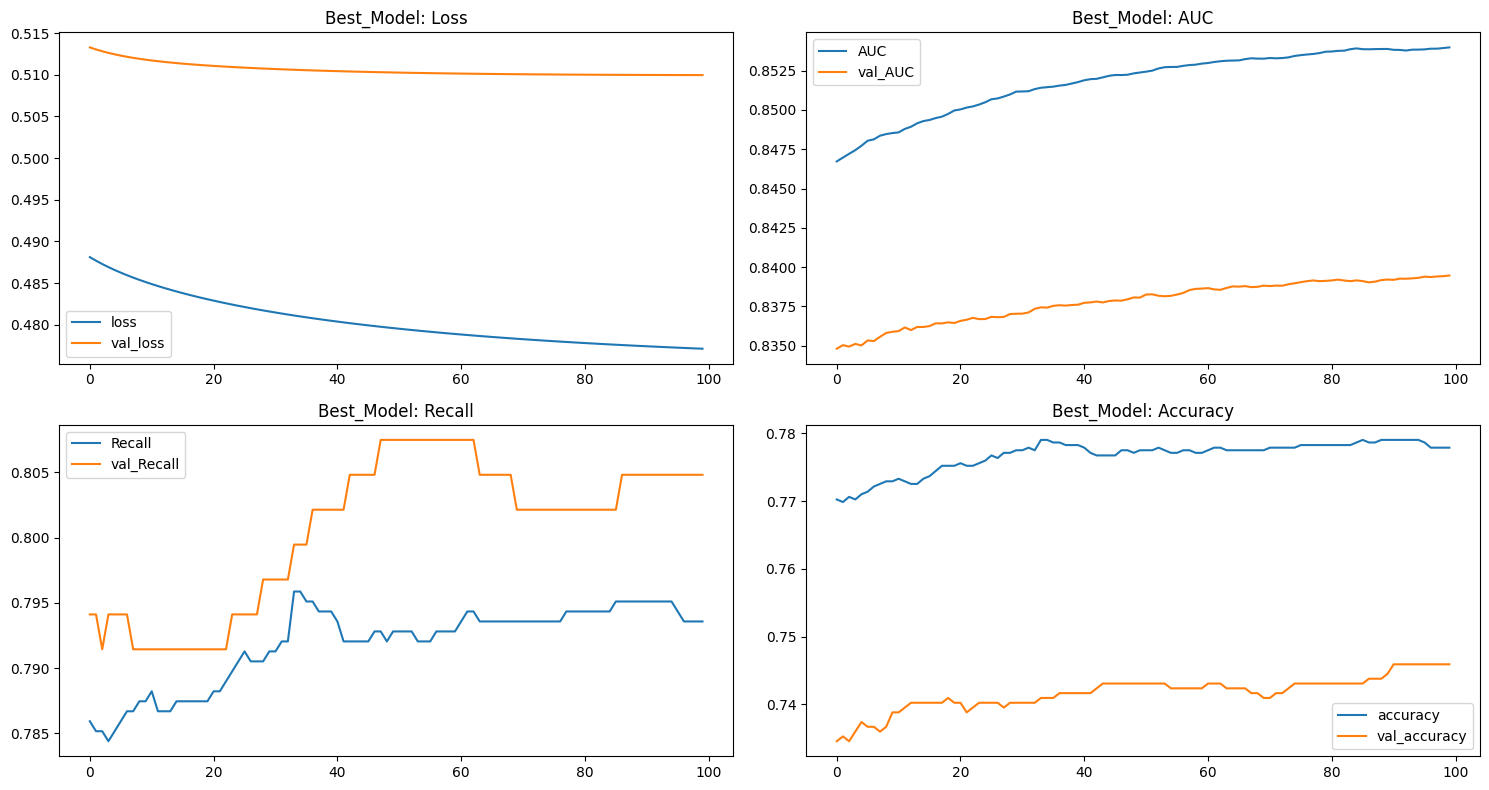

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15, 8))

final_model_history_df[["loss", "val_loss"]].plot.line(title='Best_Model: Loss', ax=axes[0,0])

final_model_history_df[["AUC", "val_AUC"]].plot.line(title='Best_Model: AUC', ax=axes[0,1])

final_model_history_df[["Recall", "val_Recall"]].plot.line(title='Best_Model: Recall', ax=axes[1,0])

final_model_history_df[["accuracy", "val_accuracy"]].plot.line(title='Best_Model: Accuracy', ax=axes[1,1])

plt.tight_layout()
plt.show()

In [ ]:
final_model_2 = tf.keras.callbacks.ModelCheckpoint('best_model_2.keras',
                                                     monitor='val_accuracy',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     mode='max')

In [ ]:
final_model_history_2 = final_model_vol_2.fit(
    X_train_undersampling, y_train_undersampling, epochs=sequentialsearch_cv_2.best_params_['epochs'],
    validation_data=(X_val, y_val), batch_size=sequentialsearch_cv_2.best_params_['batch_size'],
    callbacks=[final_model_2]
).history

Epoch 1/90
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - AUC: 0.4938 - Recall: 0.3340 - accuracy: 0.4980 - loss: 0.7163
Epoch 1: val_accuracy improved from -inf to 0.56707, saving model to best_model_2.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - AUC: 0.5049 - Recall: 0.3629 - accuracy: 0.4965 - loss: 0.7126 - val_AUC: 0.5764 - val_Recall: 0.5294 - val_accuracy: 0.5671 - val_loss: 0.6766
Epoch 2/90
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 0.5983 - Recall: 0.5560 - accuracy: 0.5645 - loss: 0.6799
Epoch 2: val_accuracy did not improve from 0.56707
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.6022 - Recall: 0.5846 - accuracy: 0.5700 - loss: 0.6769 - val_AUC: 0.6464 - val_Recall: 0.6872 - val_accuracy: 0.5649 - val_loss: 0.6638
Epoch 3/90
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - AUC: 0.6682 - Recall: 0.7230 - accuracy: 0.6270 - loss: 0.6515
Epoch 3: val_accuracy improved from 0.56707 to 0.58552, saving model to best_model_2.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 0.6704 - Recall:

In [ ]:
final_model_history_df2 = pd.DataFrame(final_model_history_2)
final_model_history_df2

,AUC,Recall,accuracy,loss,val_AUC,val_Recall,val_accuracy,val_loss
0,0.514953,0.380734,0.500000,0.709042,0.576446,0.529412,0.567069,0.676603
1,0.607913,0.600153,0.574159,0.673914,0.646408,0.687166,0.564940,0.663842
2,0.674415,0.742355,0.631116,0.646196,0.698425,0.788770,0.585522,0.649010
3,0.724729,0.795107,0.662462,0.623701,0.736243,0.812834,0.613201,0.631733
4,0.758483,0.819572,0.686927,0.604851,0.760682,0.820856,0.637331,0.612949
...,...,...,...,...,...,...,...,...
85,0.864781,0.804281,0.782875,0.459432,0.845191,0.810160,0.743790,0.506992
86,0.864962,0.804281,0.782875,0.459140,0.845198,0.810160,0.743080,0.507010
87,0.865198,0.804281,0.782875,0.458848,0.845301,0.810160,0.740951,0.507030
88,0.865369,0.803517,0.782492,0.458557,0.845449,0.807487,0.739532,0.507053


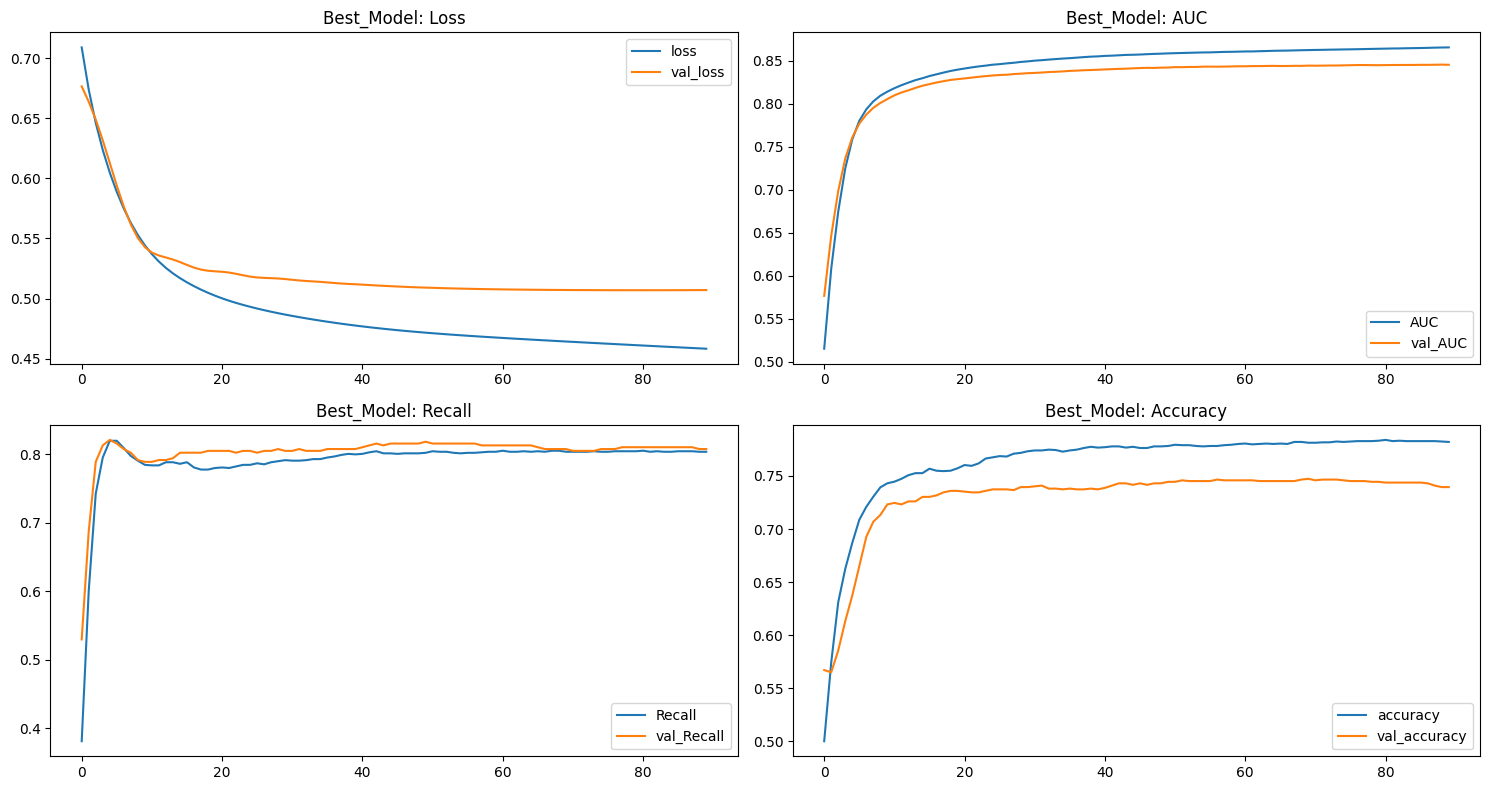

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15, 8))

final_model_history_df2[["loss", "val_loss"]].plot.line(title='Best_Model: Loss', ax=axes[0,0])

final_model_history_df2[["AUC", "val_AUC"]].plot.line(title='Best_Model: AUC', ax=axes[0,1])

final_model_history_df2[["Recall", "val_Recall"]].plot.line(title='Best_Model: Recall', ax=axes[1,0])

final_model_history_df2[["accuracy", "val_accuracy"]].plot.line(title='Best_Model: Accuracy', ax=axes[1,1])

plt.tight_layout()
plt.show()

Model neuronske mreže konstruiran od hiperparametara dobivenih Random Search pretragom pokazuje dobre performanse. Gubitak se smanjuje, dok AUC, Preciznost, Recall i Točnost rastu s brojem epoha, što ukazuje na to da model uči i poboljšava se tijekom vremena. Nema znakova prenaučenosti, jer su rezultati na trening i validacijskom skupu podataka slični. Ovo sugerira da model dobro generalizira i trebao bi dobro raditi na neviđenim podacima.

In [ ]:
final_model_test = final_model_vol_1.evaluate(X_test, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8361 - Recall: 0.7331 - accuracy: 0.7477 - loss: 0.4976


In [ ]:
predict = final_model_vol_1.predict(X_test)
predict_c = np.where(predict > 0.5, 1, 0)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
final_model_test_2 = final_model_vol_2.evaluate(X_test, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8420 - Recall: 0.7513 - accuracy: 0.7344 - loss: 0.4918 


In [ ]:
predict_2 = final_model_vol_2.predict(X_test)
predict_k = np.where(predict_2 > 0.5, 1, 0)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
predict[0]

array([0.60351235], dtype=float32)

In [ ]:
predict_c[0]

array([1])

In [ ]:
y_test.shape

(705, 1)

In [ ]:
predict_c.shape

(705, 1)

In [ ]:
print(f"Classification Report:\n{classification_report(y_test, predict_c,digits=4)}")

final_results = tf.keras.metrics.AUC()
final_results.update_state(y_test, predict)
print(f"\nAUC: {(final_results.result()*100):.2f}%")

Classification Report:
              precision    recall  f1-score   support

           0     0.8995    0.7432    0.8140       518
           1     0.5199    0.7701    0.6207       187

    accuracy                         0.7504       705
   macro avg     0.7097    0.7566    0.7173       705
weighted avg     0.7988    0.7504    0.7627       705


AUC: 84.47%


In [ ]:
print(f"Classification Report:\n{classification_report(y_test, predict_k,digits=4)}")

final_results_vol_1 = tf.keras.metrics.AUC()
final_results_vol_1.update_state(y_test, predict_2)
print(f"\nAUC: {(final_results_vol_1.result()*100):.2f}%")

Classification Report:
              precision    recall  f1-score   support

           0     0.9024    0.7317    0.8081       518
           1     0.5123    0.7807    0.6186       187

    accuracy                         0.7447       705
   macro avg     0.7073    0.7562    0.7134       705
weighted avg     0.7989    0.7447    0.7578       705


AUC: 84.79%


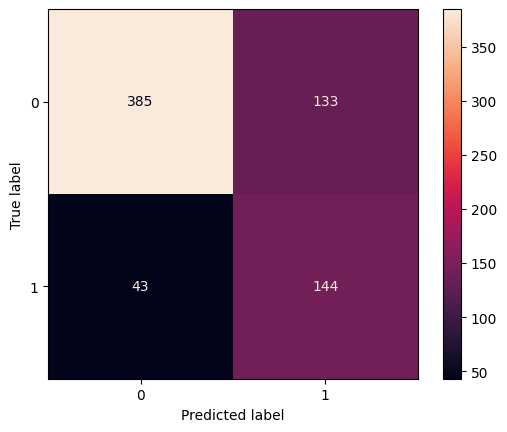

In [ ]:
matrica_konfuzije = metrics.confusion_matrix(y_test, predict_c)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrica_konfuzije)
cm_display.plot(cmap='rocket')
plt.show()

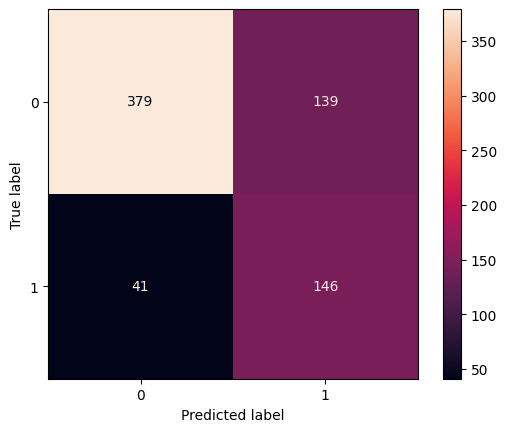

In [ ]:
matrica_konfuzije_2 = metrics.confusion_matrix(y_test, predict_k)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrica_konfuzije_2)
cm_display.plot(cmap='rocket')
plt.show()

##Usporedba rezultata
| Hiperparametar | Hyperband_1 | Hyperband_2 | RandomSearch_1 | RandomSearch_2
|----------|----------|----------|----------|----------|
| Neuroni u prvom sloju | 27 | 75 | 30 |30 |
| Neuroni u drugom sloju | 35 | 17 | 20 |17 |
| Neuroni u trećem sloju | 7 | 15 | 15 |7 |
| Aktivacijska funkcija (1) | Sigmoid | ReLU | Sigmoid |Tanh |
| Aktivacijska funkcija (2) | Sigmoid | Sigmoid | Sigmoid |Sigmoid |
| Optimizator | Adam | RMS Prop | Adagrad |Adam |
| Stopa učenja | 0.1 | 0.01 | 0.1 |0.001 |
| Broj epoha | 90 | 90 | 100 |90 |
| Veličina serije | 1024 | 1024 | 128 | 1024 |

 | Metrika | Hyperband_1 | Hyperband_2 | RandomSearch_1 | RandomSearch_2
 |----------|----------|----------|----------|----------|
 | Accuracy | 76.60% | 73.62% | 75.04% | 74.47% |
 | AUC | 82.56% | 81.02% | 84.47% |84.79% |
 | Vrijeme | 01:21:32 | 00:29:14 | 02:36:00 | 00:38:00 |
 | val_AUC | 82.56%| 84.71% | 83.61%| 84.20% |
 | val_Accuracy | 76.60% | 73.62% | 74.77% | 73.44% |
 | val_loss | 56.07% | 72.49% | 49.76% | 49.18% |
 | val_recall | 73.26% | 79.68% | 73.31% | 75.13% |

##Na osnovu rezultata pretraga može se zaključiti sljedeće:
* Modelima ne odgovara prevelik broj neurona po skrivenim slojevima.
* Optimizator Adam se pojavljuje u 2 od 4 slučaja što ukazuje na njegovu široku primjenu i prikladnost problemu korištenom u projektu.
* Kada je kombinacija sigmoidnih aktivacijskih funkcija u slojevima neuronske mreže optimizatorima više odgovara veća stopa učenja, dok kod slučaja kada je Tanh aktivacijska funkcija u skrivenim slojevima modelu više odgovara jako mala stopa učenja.
* Modelima odgovara veliki broj epoha kao i veličina serije.
* Najbolje preformanse pokazao je model konstruiran sa kombinacijom hiperparametara dobivenim pomoću Hyperband algoritma za pretragu sa manjim koeficijentom za factor.

##Daljnje istražanje:
* Skup hiperparametara koji su koristili algoritmi i na osnovu rezultata pretrage može se odrediti smjer u kojem bi se mogao proširiti skup hiperparametara s ciljem povećanja funkcionalnosti modela.
* Primjena metoda regularizacije za suzbijanje prenaučenosti modela.
* Uključivanje dodatnih parametara za istraživanje.
* Istraživanje mogućnosti dodatne obrade skupa podataka.